In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf

In [ ]:

from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import BatchNormalization
from keras.layers import GRU
from keras.layers import AveragePooling2D



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops

In [ ]:
Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data_17.head()

,Unnamed: 0,Datum,Von,bis,MW
0,Maximum,01.06.2017,11:00,11:15,7.2
1,Minimum,01.01.2017,23:00,23:15,0.0
2,Datum,Von,bis,MW,NaN
3,01.01.2017,00:00,00:15,0,NaN
4,01.01.2017,00:15,00:30,0,NaN


In [ ]:
#creation de la fonction qui va traiter les donnees
def reg_data(df):
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']

    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    df['Day'] = days
    df['Month'] = months
    df['Year'] = years

    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)

    df = df.groupby(['Day','Month','Year'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month')
    df['Day'] = df.index.get_level_values('Day')
    df['Year'] = df.index.get_level_values('Year')
    df.reset_index(drop=True, inplace=True)
    return df

#appel de la fonction reg_data


Data_10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data_14 = reg_data(Data_14)
Data_15 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data_17 = reg_data(Data_17)







#concatener tout les donnees dans une seule DataFrame
DataFrame = pd.concat([ Data_10, Data_11, Data_12, Data_13,Data_14, Data_15, Data_16, Data_17], ignore_index=True)


In [ ]:
model_data = DataFrame

In [ ]:
#standarization des donnees
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

#creer une fonction qui va faire la fraction des donnees en Data_train and DataTest
def split_data(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

#appel de la fonction "split data"
train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))

2922
2191
731


In [ ]:
#creation de lafonction qui va fractionner les donnees Xtrain and Ytrain puis Xtest and Ytest
def Split_weekly(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#Appel de la fonction Split_weekly
X_train, Y_train = Split_weekly(train)
X_test, Y_test = Split_weekly(test)

print(len(X_test))
print(len(Y_test))

print(len(X_train))
print(len(Y_train))

723
723
2183
2183


#LSTM_Attention

In [ ]:
from keras.layers import Dense, LSTM, Dropout, Input
from keras.models import Model
import tensorflow as tf

# Reshape des données d'entraînement et de test
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Définir le modèle LSTM sans Attention
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_layer = LSTM(128, return_sequences=False)(input_layer)
flatten_layer = tf.keras.layers.Flatten()(lstm_layer)
output_layer = Dense(1)(flatten_layer)

model_no_attention = Model(inputs=input_layer, outputs=output_layer)
model_no_attention.compile(optimizer='adam', loss='mean_squared_error')

# Affichage du résumé du modèle
model_no_attention.summary()

# Entraînement du modèle
history_no_attention = model_no_attention.fit(X_train, Y_train, epochs=150, batch_size=64, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

# Évaluation du modèle
train_loss_no_attention = model_no_attention.evaluate(X_train, Y_train, verbose=0)
test_loss_no_attention = model_no_attention.evaluate(X_test, Y_test, verbose=0)
print('Train Loss (No Attention): %.4f' % train_loss_no_attention)
print('Test Loss (No Attention): %.4f' % test_loss_no_attention)

# Prédiction
train_predict_no_attention = model_no_attention.predict(X_train)
test_predict_no_attention = model_no_attention.predict(X_test)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 128)               66560     
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
35/35 - 3s - loss: 0.0207 - val_loss: 0.0360 - 3s/epoch - 96ms/step
Epoch 2/150
35/35 - 1s - loss: 0.0903 - val_loss: 0.0638 - 571ms/epoch - 

In [ ]:
test_predict = model_no_attention.predict(X_test)
mse = mean_squared_error(Y_test, test_predict)

print("Mean Squared Error:", mse)

23/23 [==============================] - 0s 5ms/step
Mean Squared Error: 0.029656972683380096


#Attention

In [ ]:
from keras.layers import Dense, LSTM, Dropout, Input, Attention, Concatenate
from keras.models import Model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
attention = Attention()([lstm_layer, lstm_layer])
flatten_layer = tf.keras.layers.Flatten()(attention)
output_layer = Dense(1)(flatten_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Affichage du résumé du modèle
model.summary()

# Entraînement du modèle
history = model.fit(X_train, Y_train, epochs=150, batch_size=64, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

# Évaluation du modèle
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print('Train Loss: %.4f' % train_loss)
print('Test Loss: %.4f' % test_loss)

# Prédiction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 7, 1)]               0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 7, 128)               66560     ['input_5[0][0]']             
                                                                                                  
 attention_4 (Attention)     (None, 7, 128)               0         ['lstm_4[0][0]',              
                                                                     'lstm_4[0][0]']              
                                                                                                  
 flatten_4 (Flatten)         (None, 896)                  0         ['attention_4[0][0]']   

In [ ]:
testPredict = model.predict(X_test)
mse = mean_squared_error(Y_test, testPredict)

print("Mean Squared Error:", mse)

23/23 [==============================] - 0s 6ms/step
Mean Squared Error: 0.027527558084879503


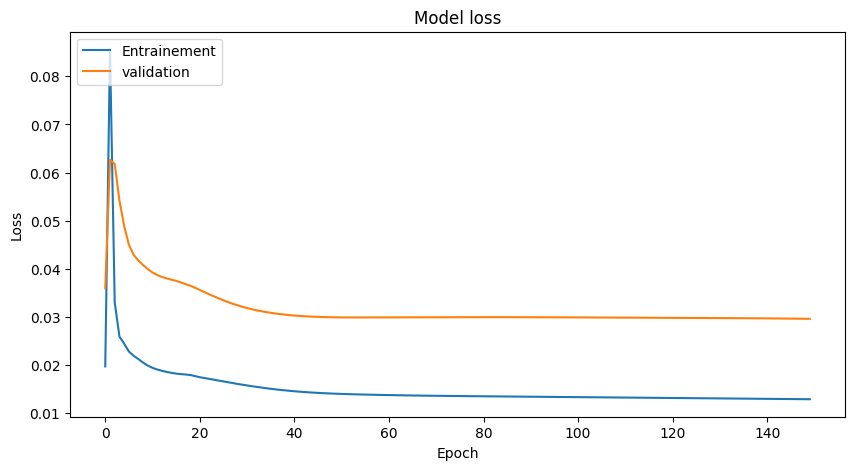

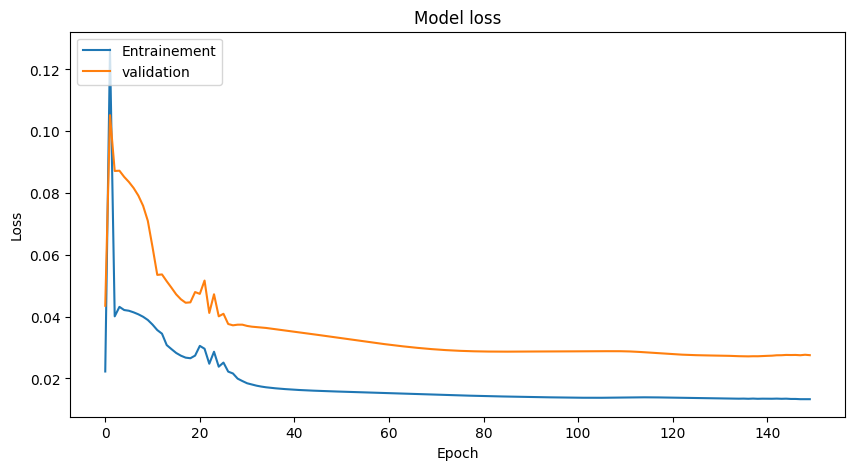

In [ ]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(10, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()


ploter_Erreur(history_no_attention)
ploter_Erreur(history)

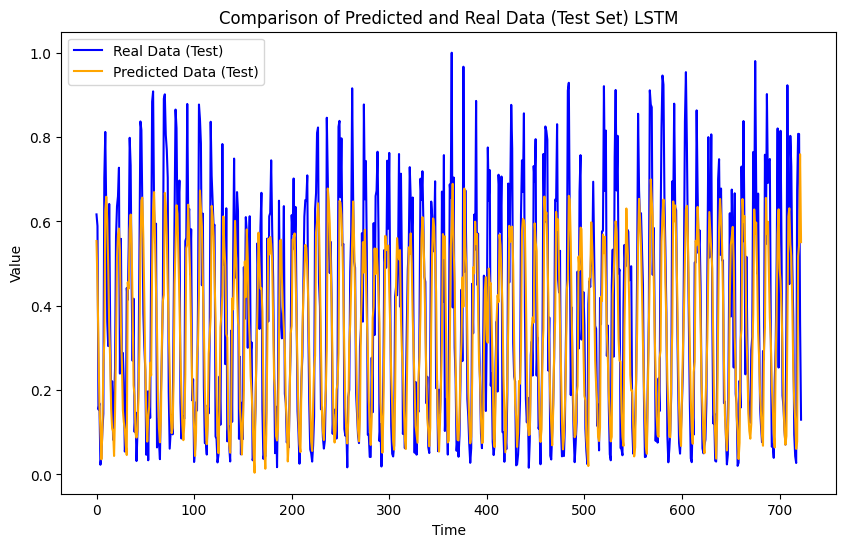

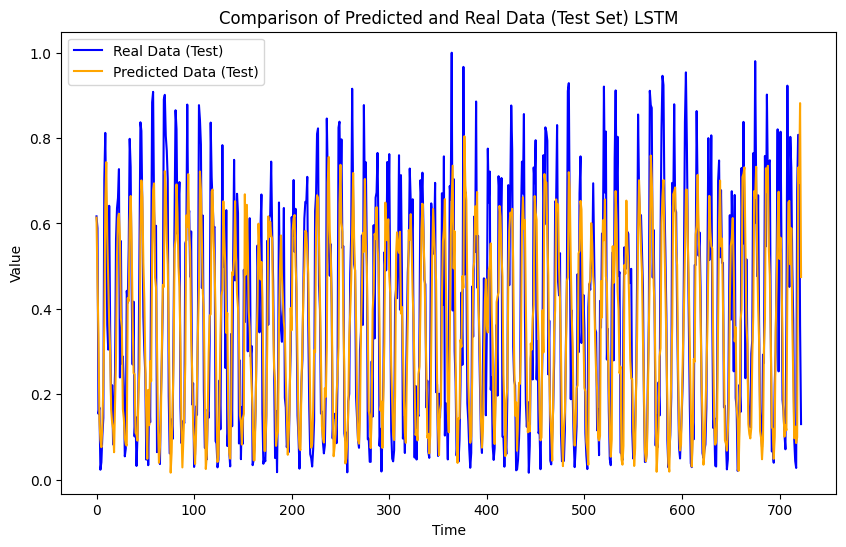

In [ ]:
# Tracer la courbe de prédiction par rapport à la réalité pour les données de test
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Real Data (Test)', color='blue')
plt.plot(test_predict_no_attention, label='Predicted Data (Test)', color='orange')
plt.title('Comparison of Predicted and Real Data (Test Set) LSTM')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Tracer la courbe de prédiction par rapport à la réalité pour les données de test
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Real Data (Test)', color='blue')
plt.plot(test_predict, label='Predicted Data (Test)', color='orange')
plt.title('Comparison of Predicted and Real Data (Test Set) LSTM')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()